In [49]:
import numpy as np
import pandas as pd
import boto3
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler


## Model Training

In [50]:
aws_access_key_id = ''
aws_secret_access_key = ''

bucket_name = ''

# Create an S3 client
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

# Specify the file key for the CSV file in AWS S3
file_key = 'with_20_keywords.csv'

# Retrieve the object from S3 bucket using the specified file key
obj = s3.get_object(Bucket=bucket_name, Key=file_key)

# Read the content of the object
content = obj['Body'].read()

# Create a Pandas DataFrame from the CSV content
final_df = pd.read_csv(BytesIO(content), engine='python')

company_encoder = LabelEncoder()
city_encoder = LabelEncoder()
state_encoder = LabelEncoder()

company_encoder.fit(final_df['Company Name'])
city_encoder.fit(final_df['City'])
state_encoder.fit(final_df['State'])

final_df['City'] = city_encoder.transform(final_df['City'])
final_df['State'] = state_encoder.transform(final_df['State'])
final_df['Company Name'] = company_encoder.transform(final_df['Company Name'])

In [51]:
final_df.head(2)

,Title,Description,Company Name,City,State,Salary,Year,Month,Day,CS_keywords,...,learn,business,responsibilities,sql,key,actionable,ability,analyses,environment,open
0,Data Scientist - Cross Asset Desk Strategist T...,Data Scientist - Cross Asset Desk Strategist T...,506,197,63,90000,2019.0,8.0,20.0,2,...,5,2,1,0,0,0,2,8,1,0
1,Senior Data Scientist - Infectious Disease and...,Senior Data Scientist - Infectious Disease Inf...,168,53,59,125000,2019.0,9.0,6.0,5,...,5,5,0,0,1,8,7,7,5,4


In [52]:
#Normalize only the numeric columns except 'Salary'
numeric_columns = final_df.select_dtypes(include=['number']).columns.drop('Salary')
scaler = MinMaxScaler()
final_df[numeric_columns] = scaler.fit_transform(final_df[numeric_columns])

#Use StandardScaler for the 'Salary' column
# Extract the 'Salary' column
salary_column = final_df['Salary']

# Calculate min and max values
salary_min = salary_column.min()
salary_max = salary_column.max()

# Perform min-max scaling manually
scaled_salary = (salary_column - salary_min) / (salary_max - salary_min)

# Update the 'Salary' column in the DataFrame
final_df['Salary'] = scaled_salary

In [53]:
final_df.head(2)

,Title,Description,Company Name,City,State,Salary,Year,Month,Day,CS_keywords,...,learn,business,responsibilities,sql,key,actionable,ability,analyses,environment,open
0,Data Scientist - Cross Asset Desk Strategist T...,Data Scientist - Cross Asset Desk Strategist T...,0.573046,0.602446,0.656250,0.140306,0.0,0.0,0.620690,0.047619,...,0.121951,0.083333,0.1,0.0,0.000000,0.000000,0.071429,0.25000,0.037037,0.000000
1,Senior Data Scientist - Infectious Disease and...,Senior Data Scientist - Infectious Disease Inf...,0.190260,0.162080,0.614583,0.233736,0.0,1.0,0.137931,0.119048,...,0.121951,0.208333,0.0,0.0,0.166667,0.210526,0.250000,0.21875,0.185185,0.210526


## Linear Regression

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'final_df' is your dataframe containing the data

# Initialize lists to store MSE and MAE values for each iteration
train_mse2_values = []
test_mse2_values = []
train_mse3_values = []
test_mse3_values = []
train_mae2_values = []
test_mae2_values = []
train_mae3_values = []
test_mae3_values = []

# Initialize lists to store weights for each iteration
weights2 = []
weights3 = []

# X2 represents data with extra keywords for predictions
X2 = final_df.drop(['Description', 'Title', 'Salary'], axis=1)

# X3 represents data without the extra keywords extracted from the job descriptions and documentation
X3 = final_df[['Company Name', 'City','State','Year','Month', 'Day']]

y2 = final_df['Salary']
y3 = final_df['Salary']

# Repeat the experiment 1000 times
for _ in range(500):
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.05)
    X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.05)
    
    model2 = LinearRegression()
    model2.fit(X_train2, y_train2)
    y_pred2 = model2.predict(X_test2)
    train_pred2 = model2.predict(X_train2)
    
    model3 = LinearRegression()
    model3.fit(X_train3, y_train3)
    y_pred3 = model3.predict(X_test3)
    train_pred3 = model3.predict(X_train3)

    # Compute MSE for model with extra keywords
    train_mse2_values.append(mean_squared_error(y_train2, train_pred2))
    test_mse2_values.append(mean_squared_error(y_test2, y_pred2))
    
    # Compute MSE for model without extra keywords
    train_mse3_values.append(mean_squared_error(y_train3, train_pred3))
    test_mse3_values.append(mean_squared_error(y_test3, y_pred3))
    
    # Compute MAE for model with extra keywords
    train_mae2_values.append(mean_absolute_error(y_train2, train_pred2))
    test_mae2_values.append(mean_absolute_error(y_test2, y_pred2))
    
    # Compute MAE for model without extra keywords
    train_mae3_values.append(mean_absolute_error(y_train3, train_pred3))
    test_mae3_values.append(mean_absolute_error(y_test3, y_pred3))
    
    # Store weights for model with extra keywords
    weights2.append(model2.coef_)
    
    # Store weights for model without extra keywords
    weights3.append(model3.coef_)

# Convert weights lists to numpy arrays
weights2 = np.array(weights2)
weights3 = np.array(weights3)

# Calculate mean and variance of weights for each model
mean_weights2 = np.mean(weights2, axis=0)
var_weights2 = np.var(weights2, axis=0)
mean_weights3 = np.mean(weights3, axis=0)
var_weights3 = np.var(weights3, axis=0)

# Calculate mean and variance of MSE and MAE values
mean_train_mse2 = np.mean(train_mse2_values)
var_train_mse2 = np.var(train_mse2_values)
mean_test_mse2 = np.mean(test_mse2_values)
var_test_mse2 = np.var(test_mse2_values)

mean_train_mse3 = np.mean(train_mse3_values)
var_train_mse3 = np.var(train_mse3_values)
mean_test_mse3 = np.mean(test_mse3_values)
var_test_mse3 = np.var(test_mse3_values)

mean_train_mae2 = np.mean(train_mae2_values)
var_train_mae2 = np.var(train_mae2_values)
mean_test_mae2 = np.mean(test_mae2_values)
var_test_mae2 = np.var(test_mae2_values)

mean_train_mae3 = np.mean(train_mae3_values)
var_train_mae3 = np.var(train_mae3_values)
mean_test_mae3 = np.mean(test_mae3_values)
var_test_mae3 = np.var(test_mae3_values)

print("Mean MSE on training set (with extra keywords):", mean_train_mse2)
print("Variance MSE on training set (with extra keywords):", var_train_mse2)
print("Mean MSE on testing set (with extra keywords):", mean_test_mse2)
print("Variance MSE on testing set (with extra keywords):", var_test_mse2)
print()
print("Mean MSE on training set (without extra keywords):", mean_train_mse3)
print("Variance MSE on training set (without extra keywords):", var_train_mse3)
print("Mean MSE on testing set (without extra keywords):", mean_test_mse3)
print("Variance MSE on testing set (without extra keywords):", var_test_mse3)

print()
print("Mean MAE on training set (with extra keywords):", mean_train_mae2)
print("Variance MAE on training set (with extra keywords):", var_train_mae2)
print("Mean MAE on testing set (with extra keywords):", mean_test_mae2)
print("Variance MAE on testing set (with extra keywords):", var_test_mae2)
print()
print("Mean MAE on training set (without extra keywords):", mean_train_mae3)
print("Variance MAE on training set (without extra keywords):", var_train_mae3)
print("Mean MAE on testing set (without extra keywords):", mean_test_mae3)
print("Variance MAE on testing set (without extra keywords):", var_test_mae3)


Mean MSE on training set (with extra keywords): 0.013037354000374219
Variance MSE on training set (with extra keywords): 4.807283151408604e-08
Mean MSE on testing set (with extra keywords): 0.013880029760034438
Variance MSE on testing set (with extra keywords): 1.773408572964251e-05

Mean MSE on training set (without extra keywords): 0.014347459506660007
Variance MSE on training set (without extra keywords): 4.530962074154544e-08
Mean MSE on testing set (without extra keywords): 0.014338510661818418
Variance MSE on testing set (without extra keywords): 1.6183903064379218e-05

Mean MAE on training set (with extra keywords): 0.08294752319789511
Variance MAE on training set (with extra keywords): 3.7961376204283703e-07
Mean MAE on testing set (with extra keywords): 0.08576058778268345
Variance MAE on testing set (with extra keywords): 9.023989102559424e-05

Mean MAE on training set (without extra keywords): 0.0885879949594248
Variance MAE on training set (without extra keywords): 3.301608

In [88]:
import numpy as np

# Assuming y_pred2 and y_test2 are your predicted and true values
# salary_max and salary_min are the max and min values for scaling

# Predict values using model2
y_pred2 = model2.predict(X_test2)

# Convert pandas Series to numpy arrays
y_pred2_array = y_pred2
y_test2_array = y_test2.to_numpy()

# Scale y_pred2
scaled_y_pred2 = y_pred2_array * (salary_max - salary_min) + salary_min

# Scale y_test2
scaled_y_test2 = y_test2_array * (salary_max - salary_min) + salary_min

# Stack scaled values side by side
scaled_values_side_by_side = np.hstack((scaled_y_pred2.reshape(-1, 1), scaled_y_test2.reshape(-1, 1)))

# Print side by side scaled values
print("Scaled Predicted values and Scaled True values:")
print(scaled_values_side_by_side)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(scaled_y_pred2 - scaled_y_test2))

# Print MAE
print("Mean Absolute Error (MAE):", mae)



Scaled Predicted values and Scaled True values:
[[105276.13734958  90000.        ]
 [129959.44551338  90000.        ]
 [143395.14073584 120000.        ]
 [119097.50842899  90000.        ]
 [143956.07764444  92000.        ]
 [104365.83412133 125000.        ]
 [ 89877.90173753  99000.        ]
 [133852.20852187 271000.        ]
 [126983.63120209 225000.        ]
 [131641.54984252  90000.        ]
 [149371.02104195 167186.        ]
 [123832.04521741 271000.        ]
 [130402.11524547 125000.        ]
 [119683.88454766  90000.        ]
 [100878.21522368 164000.        ]
 [121078.9216442  154000.        ]
 [113444.62556054 175000.        ]
 [127659.00599173 164000.        ]
 [120179.38205103 115000.        ]
 [112337.35459285  90000.        ]
 [ 98273.7290098   92000.        ]
 [150514.05991681 145000.        ]
 [128510.10287263 103000.        ]
 [ 93958.00810766  90000.        ]
 [ 33686.87578049  80000.        ]
 [120094.56828088 125000.        ]
 [130598.31539263  43000.        ]
 [14523

Mean MAE for model with extra keywords: 37440.08501245281
Mean MAE for model without extra keywords: 37440.0890084428


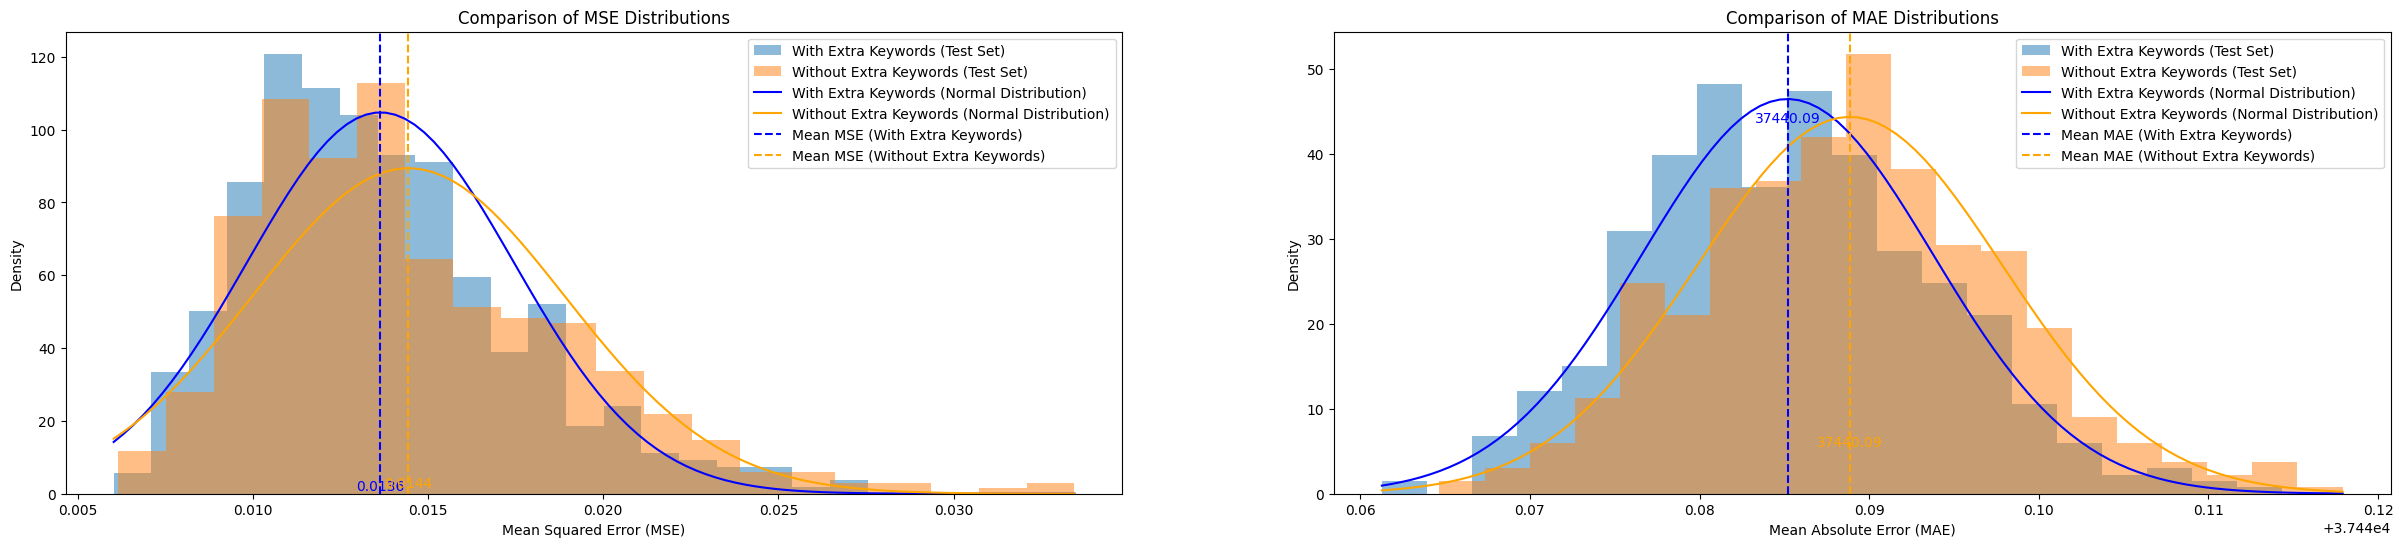

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Define the position multiplier for the mean values
position_multiplier = 0.90

# Convert the MAE values lists to NumPy arrays
real_mae2_values = test_mae2_values* (salary_max - salary_min) + salary_min
real_mae3_values = test_mae3_values * (salary_max - salary_min) + salary_min

# Calculate the mean for each array
mean_mae2 = np.mean(real_mae2_values)
mean_mae3 = np.mean(real_mae3_values)

# Print the mean values
print("Mean MAE for model with extra keywords:", mean_mae2)
print("Mean MAE for model without extra keywords:", mean_mae3)

# Create figure and axes with larger size
fig, axs = plt.subplots(1, 2, figsize=(30, 6))

# Plot for MSE distribution
# Define range for the X-axis
x_min_mse = min(min(test_mse2_values), min(test_mse3_values))
x_max_mse = max(max(test_mse2_values), max(test_mse3_values))
x_range_mse = np.linspace(x_min_mse, x_max_mse, 100)

# Plot histogram of MSE values for model with extra keywords
axs[0].hist(test_mse2_values, bins=20, density=True, alpha=0.5, label='With Extra Keywords (Test Set)')
axs[0].hist(test_mse3_values, bins=20, density=True, alpha=0.5, label='Without Extra Keywords (Test Set)')

# Plot normal distribution curve for model with extra keywords
mu2_mse, std2_mse = mean_test_mse2, np.sqrt(var_test_mse2)
axs[0].plot(x_range_mse, norm.pdf(x_range_mse, mu2_mse, std2_mse), label='With Extra Keywords (Normal Distribution)', color='blue')

# Plot normal distribution curve for model without extra keywords
mu3_mse, std3_mse = mean_test_mse3, np.sqrt(var_test_mse3)
axs[0].plot(x_range_mse, norm.pdf(x_range_mse, mu3_mse, std3_mse), label='Without Extra Keywords (Normal Distribution)', color='orange')

# Add vertical lines for mean
axs[0].axvline(x=mu2_mse, color='blue', linestyle='--', label='Mean MSE (With Extra Keywords)')
axs[0].axvline(x=mu3_mse, color='orange', linestyle='--', label='Mean MSE (Without Extra Keywords)')

# Annotate the vertical lines with mean values
axs[0].text(mu2_mse, 0.002, f'{mu2_mse:.4f}', color='blue', ha='center', va='bottom')
axs[0].text(mu3_mse, 1, f'{mu3_mse:.4f}', color='orange', ha='center', va='bottom')

# Add legend and labels
axs[0].legend()
axs[0].set_xlabel('Mean Squared Error (MSE)')
axs[0].set_ylabel('Density')
axs[0].set_title('Comparison of MSE Distributions')

# Plot for MAE distribution
# Calculate maximum density value for each model
max_density2_mae = max(np.histogram(real_mae2_values, bins=20, density=True)[0])
max_density3_mae = max(np.histogram(real_mae3_values, bins=20, density=True)[0])

# Define range for the X-axis
x_min_mae = min(min(real_mae2_values), min(real_mae3_values))
x_max_mae = max(max(real_mae2_values), max(real_mae3_values))
x_range_mae = np.linspace(x_min_mae, x_max_mae, 100)

# Plot histogram of MAE values for model with extra keywords
axs[1].hist(real_mae2_values, bins=20, density=True, alpha=0.5, label='With Extra Keywords (Test Set)')
axs[1].hist(real_mae3_values, bins=20, density=True, alpha=0.5, label='Without Extra Keywords (Test Set)')

# Plot normal distribution curve for model with extra keywords
mu2_mae, std2_mae = np.mean(real_mae2_values), np.std(real_mae2_values)
axs[1].plot(x_range_mae, norm.pdf(x_range_mae, mu2_mae, std2_mae), label='With Extra Keywords (Normal Distribution)', color='blue')

# Plot normal distribution curve for model without extra keywords
mu3_mae, std3_mae = np.mean(real_mae3_values), np.std(real_mae3_values)
axs[1].plot(x_range_mae, norm.pdf(x_range_mae, mu3_mae, std3_mae), label='Without Extra Keywords (Normal Distribution)', color='orange')

# Add vertical lines for mean
axs[1].axvline(x=mu2_mae, color='blue', linestyle='--', label='Mean MAE (With Extra Keywords)')
axs[1].axvline(x=mu3_mae, color='orange', linestyle='--', label='Mean MAE (Without Extra Keywords)')

# Annotate the vertical lines with mean values
axs[1].text(mu2_mae, max_density2_mae * position_multiplier, f'{mu2_mae:.2f}', color='blue', ha='center', va='bottom')
axs[1].text(mu3_mae, max_density3_mae * (1-position_multiplier), f'{mu3_mae:.2f}', color='orange', ha='center', va='bottom')

# Add legend and labels
axs[1].legend()
axs[1].set_xlabel('Mean Absolute Error (MAE)')
axs[1].set_ylabel('Density')
axs[1].set_title('Comparison of MAE Distributions')

# Show plot
plt.show()

In [57]:
column_names = X2.columns.tolist()
print(column_names)

['Company Name', 'City', 'State', 'Year', 'Month', 'Day', 'CS_keywords', 'data', 'work', 'python', 'experience', 'scientist', 'new', 'opportunities', 'insights', 'skills', 'problems', 'help', 'communication', 'drive', 'including', 'build', 'team', 'programming', 'passion', 'statistics', 'ca', 'learn', 'business', 'responsibilities', 'sql', 'key', 'actionable', 'ability', 'analyses', 'environment', 'open']


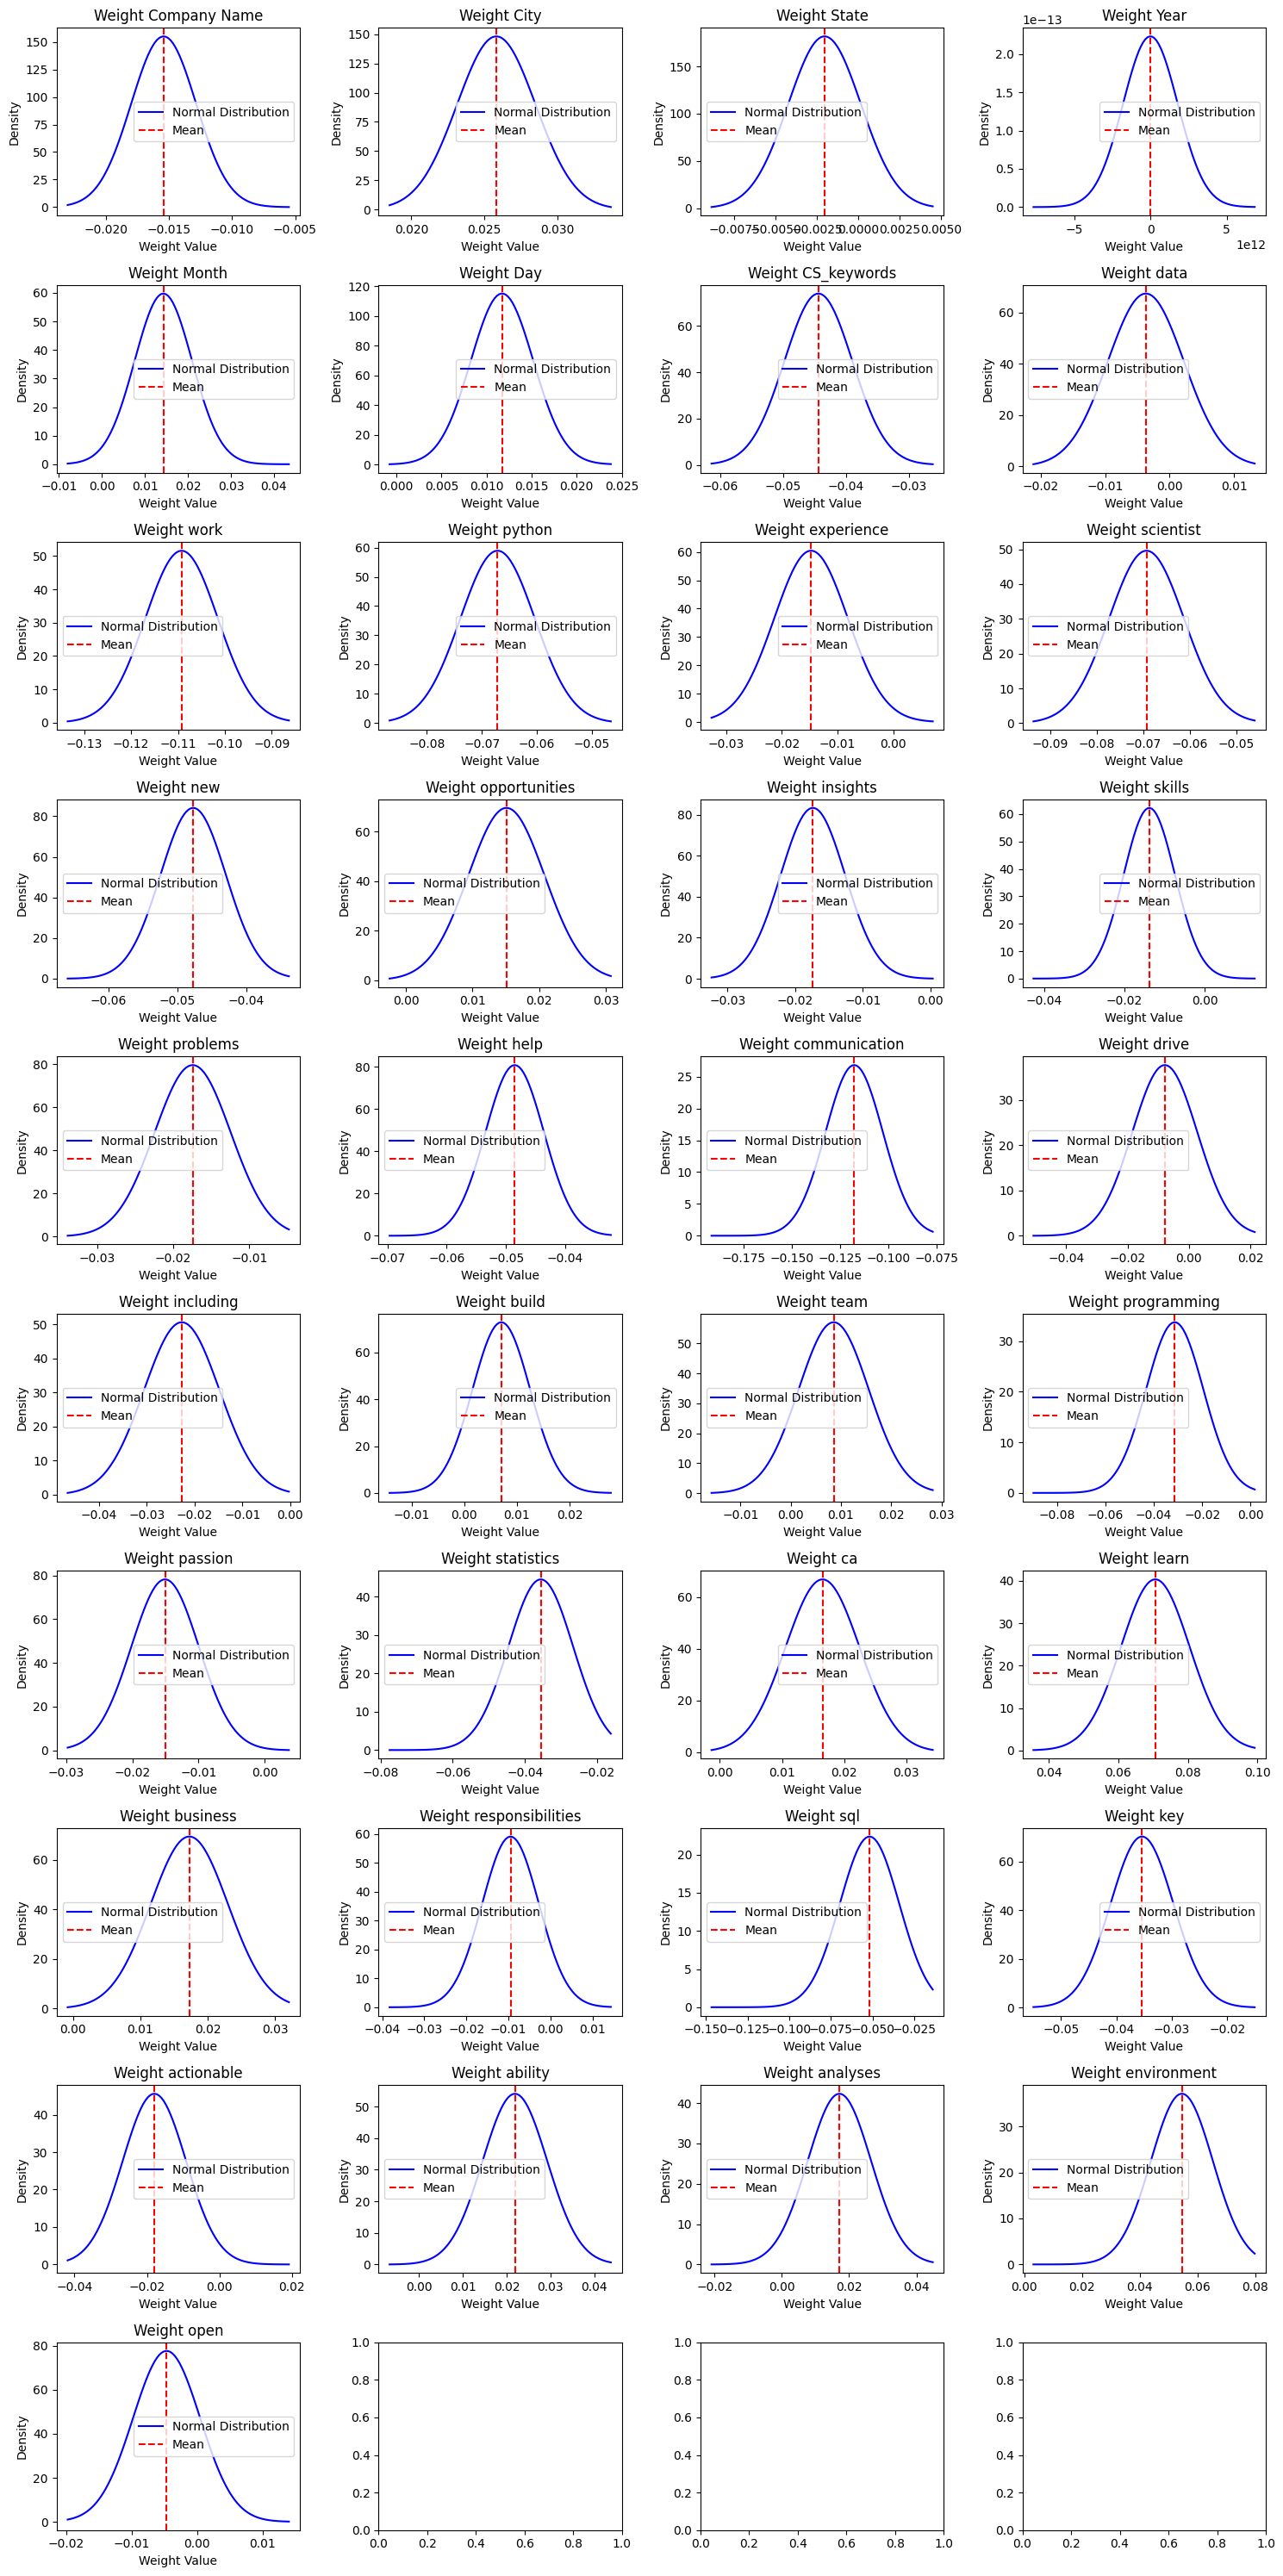

In [58]:
# Calculate the number of weights
num_weights = len(weights2[0])

# Calculate the number of rows and columns for the subplot matrix
num_cols = 4  # Set the number of columns as desired
num_rows = (num_weights + num_cols - 1) // num_cols  # Ensure at least num_cols in a row

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Iterate over each weight
for i in range(num_weights):
    # Extract weight values for the current weight
    weight_values = [weight[i] for weight in weights2]

    # Calculate mean and standard deviation of the weight values
    mean = np.mean(weight_values)
    std_dev = np.std(weight_values)
    
    # Plot the normal distribution of the weight
    x_min = min(weight_values)
    x_max = max(weight_values)
    x_range = np.linspace(x_min, x_max, 100)
    axs[i].plot(x_range, norm.pdf(x_range, mean, std_dev), label='Normal Distribution', color='blue')
    
    # Add vertical line for the mean
    axs[i].axvline(x=mean, color='red', linestyle='--', label='Mean')
    
    # Set title for the subplot
    axs[i].set_title(f'Weight {X2.columns.tolist()[i]}')
    
    # Set labels and legend
    axs[i].set_xlabel('Weight Value')
    axs[i].set_ylabel('Density')
    axs[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()



In [59]:
X2.head(2)

,Company Name,City,State,Year,Month,Day,CS_keywords,data,work,python,...,learn,business,responsibilities,sql,key,actionable,ability,analyses,environment,open
0,0.573046,0.602446,0.656250,0.0,0.0,0.620690,0.047619,0.107143,0.250000,0.111111,...,0.121951,0.083333,0.1,0.0,0.000000,0.000000,0.071429,0.25000,0.037037,0.000000
1,0.190260,0.162080,0.614583,0.0,1.0,0.137931,0.119048,0.160714,0.071429,0.000000,...,0.121951,0.208333,0.0,0.0,0.166667,0.210526,0.250000,0.21875,0.185185,0.210526


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize lists to store MSE and MAE values for each iteration
train_mse2_values = []
test_mse2_values = []
train_mse3_values = []
test_mse3_values = []
train_mae2_values = []
test_mae2_values = []
train_mae3_values = []
test_mae3_values = []

# X2 represents data with extra keywords for predictions
X2 = final_df.drop(['Description', 'Title', 'Salary'], axis=1)

# X3 represents data without the extra keywords extracted from the job descriptions and documentation
X3 = final_df[['Company Name', 'City', 'State', 'Year', 'Month', 'Day']]

y2 = final_df['Salary']
y3 = final_df['Salary']

# Repeat the experiment 100 times
for _ in range(1):
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.05)
    X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.05)
    
    model2 = MLPRegressor(hidden_layer_sizes=(1, 1), learning_rate_init=0.01, max_iter=1, activation='relu', solver='adam')
    model2.fit(X_train2, y_train2)
    y_pred2 = model2.predict(X_test2)
    train_pred2 = model2.predict(X_train2)
    
    model3 = MLPRegressor(hidden_layer_sizes=(1, 1), learning_rate_init=0.01, max_iter=1, activation='relu', solver='adam')
    model3.fit(X_train3, y_train3)
    y_pred3 = model3.predict(X_test3)
    train_pred3 = model3.predict(X_train3)

    # Compute MSE for model with extra keywords
    train_mse2_values.append(mean_squared_error(y_train2, train_pred2))
    test_mse2_values.append(mean_squared_error(y_test2, y_pred2))
    
    # Compute MSE for model without extra keywords
    train_mse3_values.append(mean_squared_error(y_train3, train_pred3))
    test_mse3_values.append(mean_squared_error(y_test3, y_pred3))
    
    # Compute MAE for model with extra keywords
    train_mae2_values.append(mean_absolute_error(y_train2, train_pred2))
    test_mae2_values.append(mean_absolute_error(y_test2, y_pred2))
    
    # Compute MAE for model without extra keywords
    train_mae3_values.append(mean_absolute_error(y_train3, train_pred3))
    test_mae3_values.append(mean_absolute_error(y_test3, y_pred3))

# Calculate mean and variance of MSE and MAE values
mean_train_mse2 = np.mean(train_mse2_values)
var_train_mse2 = np.var(train_mse2_values)
mean_test_mse2 = np.mean(test_mse2_values)
var_test_mse2 = np.var(test_mse2_values)

mean_train_mse3 = np.mean(train_mse3_values)
var_train_mse3 = np.var(train_mse3_values)
mean_test_mse3 = np.mean(test_mse3_values)
var_test_mse3 = np.var(test_mse3_values)

mean_train_mae2 = np.mean(train_mae2_values)
var_train_mae2 = np.var(train_mae2_values)
mean_test_mae2 = np.mean(test_mae2_values)
var_test_mae2 = np.var(test_mae2_values)

mean_train_mae3 = np.mean(train_mae3_values)
var_train_mae3 = np.var(train_mae3_values)
mean_test_mae3 = np.mean(test_mae3_values)
var_test_mae3 = np.var(test_mae3_values)

print("Mean MSE on training set (with extra keywords):", mean_train_mse2)
print("Variance MSE on training set (with extra keywords):", var_train_mse2)
print("Mean MSE on testing set (with extra keywords):", mean_test_mse2)
print("Variance MSE on testing set (with extra keywords):", var_test_mse2)
print()
print("Mean MSE on training set (without extra keywords):", mean_train_mse3)
print("Variance MSE on training set (without extra keywords):", var_train_mse3)
print("Mean MSE on testing set (without extra keywords):", mean_test_mse3)
print("Variance MSE on testing set (without extra keywords):", var_test_mse3)

print()
print("Mean MAE on training set (with extra keywords):", mean_train_mae2)
print("Variance MAE on training set (with extra keywords):", var_train_mae2)
print("Mean MAE on testing set (with extra keywords):", mean_test_mae2)
print("Variance MAE on testing set (with extra keywords):", var_test_mae2)
print()
print("Mean MAE on training set (without extra keywords):", mean_train_mae3)
print("Variance MAE on training set (without extra keywords):", var_train_mae3)
print("Mean MAE on testing set (without extra keywords):", mean_test_mae3)
print("Variance MAE on testing set (without extra keywords):", var_test_mae3)


Mean MSE on training set (with extra keywords): 11.53688629035425
Variance MSE on training set (with extra keywords): 0.0
Mean MSE on testing set (with extra keywords): 11.538785788042617
Variance MSE on testing set (with extra keywords): 0.0

Mean MSE on training set (without extra keywords): 1.4859329176843468
Variance MSE on training set (without extra keywords): 0.0
Mean MSE on testing set (without extra keywords): 1.467350008246745
Variance MSE on testing set (without extra keywords): 0.0

Mean MAE on training set (with extra keywords): 3.3941666581108874
Variance MAE on training set (with extra keywords): 0.0
Mean MAE on testing set (with extra keywords): 3.3948189701698808
Variance MAE on testing set (with extra keywords): 0.0

Mean MAE on training set (without extra keywords): 1.2094658229565756
Variance MAE on training set (without extra keywords): 0.0
Mean MAE on testing set (without extra keywords): 1.197879058107944
Variance MAE on testing set (without extra keywords): 0.0


/home/ubuntu/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean MAE for model with extra keywords: 37440.09462294419
Mean MAE for model without extra keywords: 37440.57110642914


/home/ubuntu/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/ubuntu/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


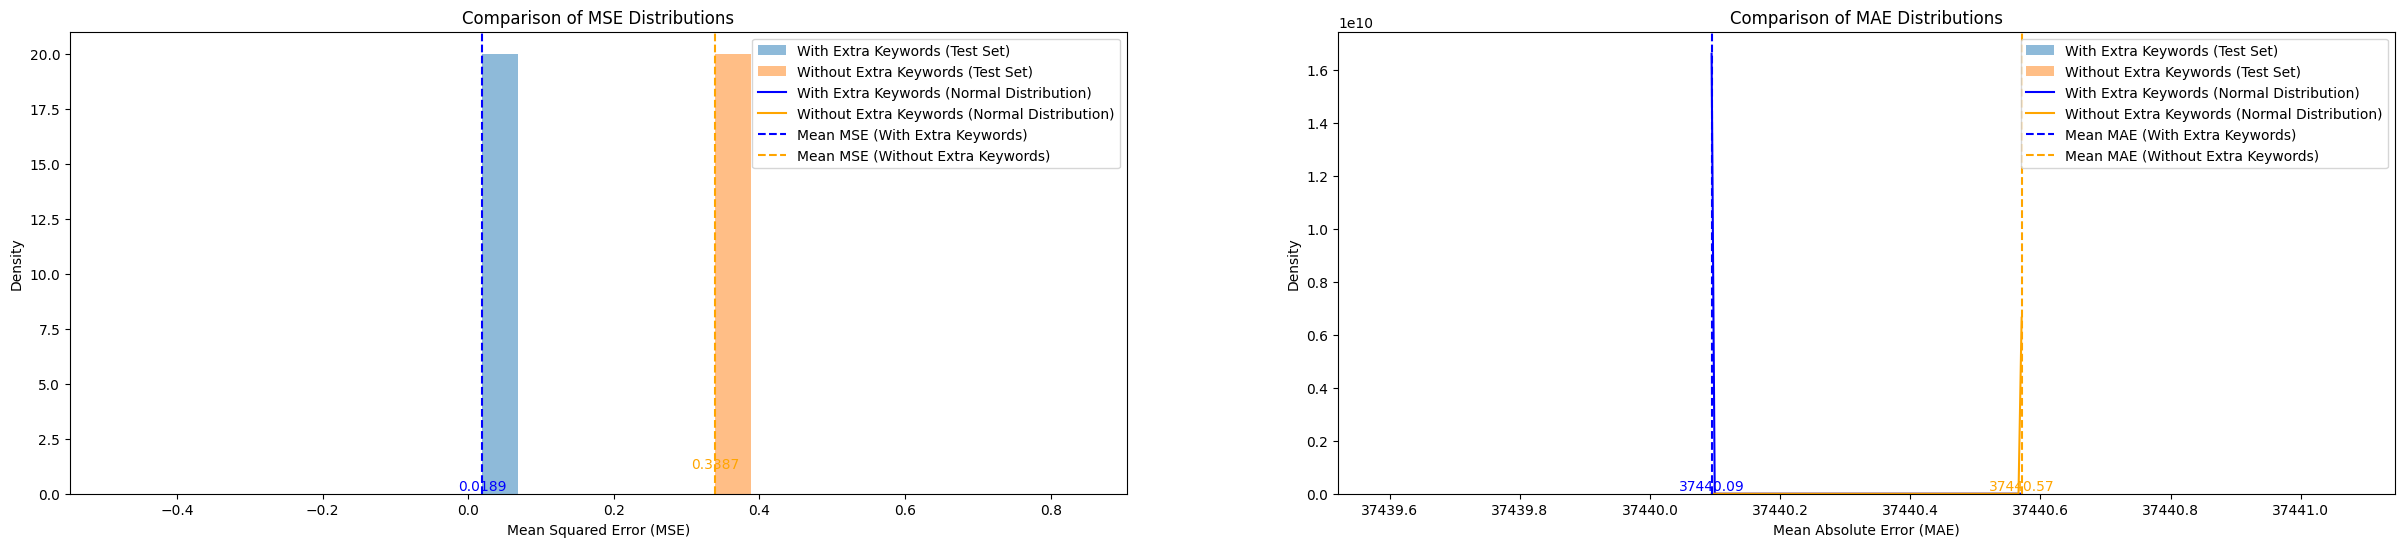

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Define the position multiplier for the mean values
position_multiplier = 0.90

# Convert the MAE values lists to NumPy arrays
real_mae2_values = test_mae2_values* (salary_max - salary_min) + salary_min
real_mae3_values = test_mae3_values * (salary_max - salary_min) + salary_min

# Calculate the mean for each array
mean_mae2 = np.mean(real_mae2_values)
mean_mae3 = np.mean(real_mae3_values)

# Print the mean values
print("Mean MAE for model with extra keywords:", mean_mae2)
print("Mean MAE for model without extra keywords:", mean_mae3)

# Create figure and axes with larger size
fig, axs = plt.subplots(1, 2, figsize=(30, 6))

# Plot for MSE distribution
# Define range for the X-axis
x_min_mse = min(min(test_mse2_values), min(test_mse3_values))
x_max_mse = max(max(test_mse2_values), max(test_mse3_values))
x_range_mse = np.linspace(x_min_mse, x_max_mse, 100)

# Plot histogram of MSE values for model with extra keywords
axs[0].hist(test_mse2_values, bins=20, density=True, alpha=0.5, label='With Extra Keywords (Test Set)')
axs[0].hist(test_mse3_values, bins=20, density=True, alpha=0.5, label='Without Extra Keywords (Test Set)')

# Plot normal distribution curve for model with extra keywords
mu2_mse, std2_mse = mean_test_mse2, np.sqrt(var_test_mse2)
axs[0].plot(x_range_mse, norm.pdf(x_range_mse, mu2_mse, std2_mse), label='With Extra Keywords (Normal Distribution)', color='blue')

# Plot normal distribution curve for model without extra keywords
mu3_mse, std3_mse = mean_test_mse3, np.sqrt(var_test_mse3)
axs[0].plot(x_range_mse, norm.pdf(x_range_mse, mu3_mse, std3_mse), label='Without Extra Keywords (Normal Distribution)', color='orange')

# Add vertical lines for mean
axs[0].axvline(x=mu2_mse, color='blue', linestyle='--', label='Mean MSE (With Extra Keywords)')
axs[0].axvline(x=mu3_mse, color='orange', linestyle='--', label='Mean MSE (Without Extra Keywords)')

# Annotate the vertical lines with mean values
axs[0].text(mu2_mse, 0.002, f'{mu2_mse:.4f}', color='blue', ha='center', va='bottom')
axs[0].text(mu3_mse, 1, f'{mu3_mse:.4f}', color='orange', ha='center', va='bottom')

# Add legend and labels
axs[0].legend()
axs[0].set_xlabel('Mean Squared Error (MSE)')
axs[0].set_ylabel('Density')
axs[0].set_title('Comparison of MSE Distributions')

# Plot for MAE distribution
# Calculate maximum density value for each model
max_density2_mae = max(np.histogram(real_mae2_values, bins=20, density=True)[0])
max_density3_mae = max(np.histogram(real_mae3_values, bins=20, density=True)[0])

# Define range for the X-axis
x_min_mae = min(min(real_mae2_values), min(real_mae3_values))
x_max_mae = max(max(real_mae2_values), max(real_mae3_values))
x_range_mae = np.linspace(x_min_mae, x_max_mae, 100)

# Plot histogram of MAE values for model with extra keywords
axs[1].hist(real_mae2_values, bins=20, density=True, alpha=0.5, label='With Extra Keywords (Test Set)')
axs[1].hist(real_mae3_values, bins=20, density=True, alpha=0.5, label='Without Extra Keywords (Test Set)')

# Plot normal distribution curve for model with extra keywords
mu2_mae, std2_mae = np.mean(real_mae2_values), np.std(real_mae2_values)
axs[1].plot(x_range_mae, norm.pdf(x_range_mae, mu2_mae, std2_mae), label='With Extra Keywords (Normal Distribution)', color='blue')

# Plot normal distribution curve for model without extra keywords
mu3_mae, std3_mae = np.mean(real_mae3_values), np.std(real_mae3_values)
axs[1].plot(x_range_mae, norm.pdf(x_range_mae, mu3_mae, std3_mae), label='Without Extra Keywords (Normal Distribution)', color='orange')

# Add vertical lines for mean
axs[1].axvline(x=mu2_mae, color='blue', linestyle='--', label='Mean MAE (With Extra Keywords)')
axs[1].axvline(x=mu3_mae, color='orange', linestyle='--', label='Mean MAE (Without Extra Keywords)')

# Annotate the vertical lines with mean values
axs[1].text(mu2_mae, max_density2_mae * position_multiplier, f'{mu2_mae:.2f}', color='blue', ha='center', va='bottom')
axs[1].text(mu3_mae, max_density3_mae * (1-position_multiplier), f'{mu3_mae:.2f}', color='orange', ha='center', va='bottom')

# Add legend and labels
axs[1].legend()
axs[1].set_xlabel('Mean Absolute Error (MAE)')
axs[1].set_ylabel('Density')
axs[1].set_title('Comparison of MAE Distributions')

# Show plot
plt.show()
